# Sentiment Analysis of Patient Drug Reviews

This notebook explores patient-written drug reviews using an end-to-end NLP workflow:
- Construction of unified review text from multiple fields
- Exploratory analysis of ratings, conditions, and drugs
- Lexicon-based sentiment baseline (VADER)
- Transformer embeddings (Bio_ClinicalBERT) with a Logistic Regression classifier

**Label note:** Numeric ratings are converted into binary sentiment labels as a proxy for sentiment; some label noise is expected.


## Exploratory Data Analysis


In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [4]:
# helper functions for creating the plots 

def plot_vader_density_with_peaks(df):
    plt.figure(figsize=(7, 4))
    hue_order = ["negative", "positive"]
    ax = sns.kdeplot(data=df, x="vader_compound", hue="sentiment_label",
                     hue_order=hue_order, common_norm=False, fill=False)
    plt.title("Density of VADER Compound Scores by Sentiment Label")
    plt.xlabel("VADER Compound Score")
    plt.ylabel("Density")
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    
    for line, label in zip(ax.lines, hue_order):
        xs, ys = line.get_data()
        ys = np.asarray(ys)
        if ys.size < 3:
            continue
        peak_idx = np.where((ys[1:-1] > ys[:-2]) & (ys[1:-1] > ys[2:]))[0] + 1
        if len(peak_idx) == 0:
            continue
        top_peaks = peak_idx[np.argsort(ys[peak_idx])[::-1]][:2]

        print(f"\n{label} peaks:")
        for k, i in enumerate(top_peaks, start=1):
            x_peak, y_peak = xs[i], ys[i]
            ax.plot(x_peak, y_peak, "o", color=line.get_color())
            ax.text(x_peak, y_peak + 0.03 + 0.03 * (k - 1),
                    f"peak {k}\n(x={x_peak:.2f}, y={y_peak:.2f})",
                    ha="center", color=line.get_color())
            print(f"  peak {k}: density = {y_peak:.4f} at score {x_peak:.4f}")
    plt.tight_layout()
    plt.show()

def plot_clinicalbert_density_with_peaks(df):
    plt.figure(figsize=(7, 4))
    ax = sns.kdeplot(data=df, x="clinicalbert_score", hue="sentiment_label",
                     common_norm=False, fill=False)
    plt.title("Density of Bio_ClinicalBERT Polarity Scores by Rating-Derived Label")
    plt.xlabel("Polarity score (p_pos - p_neg)")
    plt.ylabel("Density")
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    
    for line in ax.lines:
        xs, ys = line.get_data()
        ys = np.asarray(ys)
        if ys.size < 3:
            continue
        cond = (ys[1:-1] > ys[:-2]) & (ys[1:-1] > ys[2:])
        peak_idx = np.nonzero(np.atleast_1d(cond))[0] + 1
        if peak_idx.size == 0:
            continue
        top_peaks = peak_idx[np.argsort(ys[peak_idx])[::-1]][:2]

        for k, i in enumerate(top_peaks, start=1):
            x_peak, y_peak = xs[i], ys[i]
            ax.plot(x_peak, y_peak, "o", color=line.get_color())
            ax.text(x_peak, y_peak + 0.03 + 0.03 * (k - 1),
                    f"peak {k}\n(x={x_peak:.2f}, y={y_peak:.2f})",
                    ha="center", color=line.get_color())
            print(f"peak {k}: density = {y_peak:.4f} at score {x_peak:.4f}")
    plt.tight_layout()
    plt.show()

### Load Data


In [6]:
# Data note:
# The dataset is loaded from local files and is not included in this repository.
# The original train/test split provided by DrugLib is preserved via the `split` column.

In [7]:
data_path = "drug+review+dataset+druglib+com"  # local path; dataset not included in repo

train_df = pd.read_csv(os.path.join(data_path, "drugLibTrain_raw.tsv"), sep="\t")
test_df = pd.read_csv(os.path.join(data_path, "drugLibTest_raw.tsv"),sep="\t")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())

Train shape: (3107, 9)
Test shape: (1036, 9)
Train columns: ['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects', 'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview']
Test columns: ['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects', 'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview']


In [8]:
# Combine provided train/test splits for EDA

# Adding a column to remember where each row came from 
train_df["split"] = "train"
test_df["split"] = "test"

# Combine into one df
df = pd.concat([train_df, test_df], ignore_index=True)

print("Combined shape:", df.shape)

Combined shape: (4143, 10)


In [9]:
# Checking for missing values in the concatenated df 
print(df.isna().sum())

Unnamed: 0            0
urlDrugName           0
rating                0
effectiveness         0
sideEffects           0
condition             1
benefitsReview       23
sideEffectsReview    98
commentsReview       13
split                 0
dtype: int64


### Unified review text (`overall_review`)

The dataset stores review content across three fields (`benefitsReview`, `sideEffectsReview`, `commentsReview`).  
These are concatenated into a single text column (`overall_review`) to represent the full patient narrative.

In [11]:
# Missing review fields are treated as empty strings.
# Rows with no usable text across all three fields are removed.

# Filling missing text fields with empty strings
text_cols = ["benefitsReview", "sideEffectsReview", "commentsReview"]
df[text_cols] = df[text_cols].fillna("")

# Creating overall_review
df["overall_review"] = (
    df["benefitsReview"].str.strip() + " " +
    df["sideEffectsReview"].str.strip() + " " +
    df["commentsReview"].str.strip()
)

# Cleaning up extra whitespaces
df["overall_review"] = (
    df["overall_review"]
    .str.replace(r"\s+", " ", regex=True) # any sequence of more than 1 whitespace character
    .str.strip()
)

# Dropping rows with completely empty overall_review
empty_overall = (df["overall_review"].str.len() == 0).sum()
print("Num of rows with completely empty overall_review before filtering:", empty_overall)

df = df[df["overall_review"].str.len() > 0].reset_index(drop=True)
print("New shape after dropping empty overall_review rows:", df.shape)

Num of rows with completely empty overall_review before filtering: 1
New shape after dropping empty overall_review rows: (4142, 11)


### Binary sentiment labels

Ratings are converted into binary sentiment labels as a proxy:
- rating > 5 → positive
- rating ≤ 5 → negative

In [13]:
df["sentiment_label"] = np.where(df["rating"] > 5, "positive", "negative")
print(df["sentiment_label"].value_counts())

sentiment_label
positive    3014
negative    1128
Name: count, dtype: int64


### 	Analyze distribution of ratings

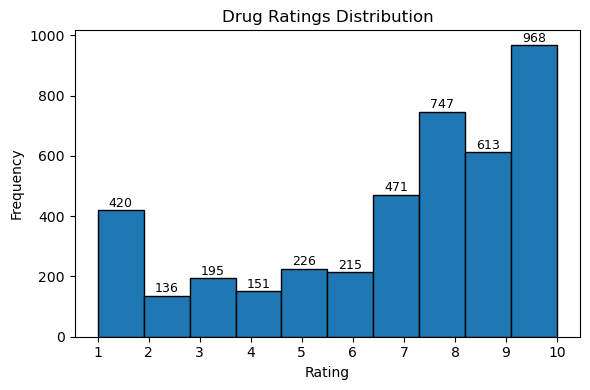

In [15]:
plt.figure(figsize=(6,4))
counts, bin_edges, patches = plt.hist(df["rating"], bins=10, edgecolor="black")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Drug Ratings Distribution")
plt.xticks(range(1, 11))
for count, left, right in zip(counts, bin_edges[:-1], bin_edges[1:]):
    if count > 0:  
        x = (left + right) / 2  
        y = count
        plt.text(x, y + 1, int(count), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

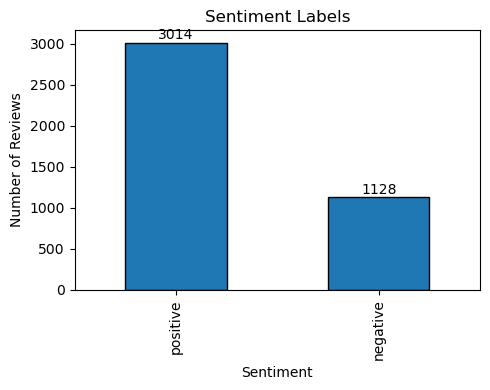

In [16]:
sent_counts = df["sentiment_label"].value_counts()

plt.figure(figsize=(5,4))
ax = sent_counts.plot(kind="bar", edgecolor="black")
plt.title("Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
for i, v in enumerate(sent_counts.values):
    ax.text(i, v + 5, str(v), ha="center", va="bottom")
plt.tight_layout()
plt.show()

### Top conditions by review count bar plot

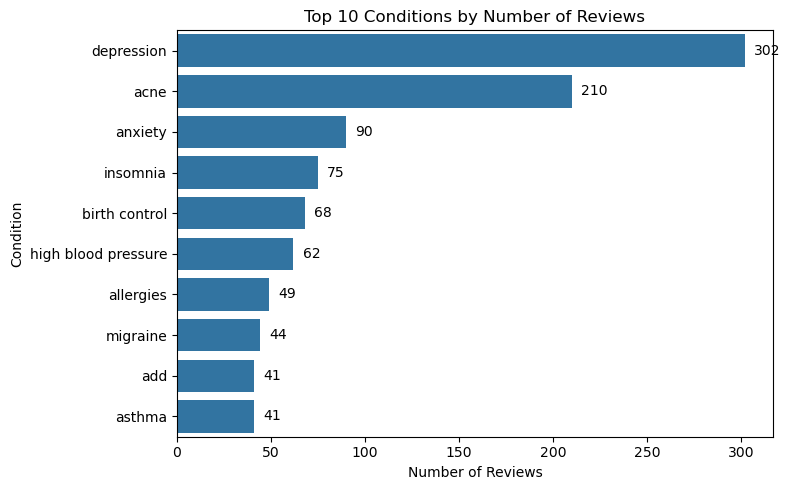

In [18]:
# Taking the top 10 conditions
cond_counts = df["condition"].dropna().value_counts().head(10)

# Plotting
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=cond_counts.values,
    y=cond_counts.index)
plt.title("Top 10 Conditions by Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Condition")
for i, v in enumerate(cond_counts.values):
    ax.text(v + 5, i, str(v), va="center")
plt.tight_layout()
plt.show()

### Average rating by condition to see which conditions have better treatment satisfaction.


In [20]:
# Grouping by condition and for each calculating the average rating
cond_stats = (
    df.groupby("condition")["rating"]
      .agg(avg_rating="mean", review_count="size").dropna())

# Picking the top 10 conditions by number of reviews
top10_conditions = (cond_stats.sort_values("review_count", ascending=False).head(10))

# Sorting by average rating
top10_for_plot = top10_conditions.sort_values("avg_rating", ascending=False)

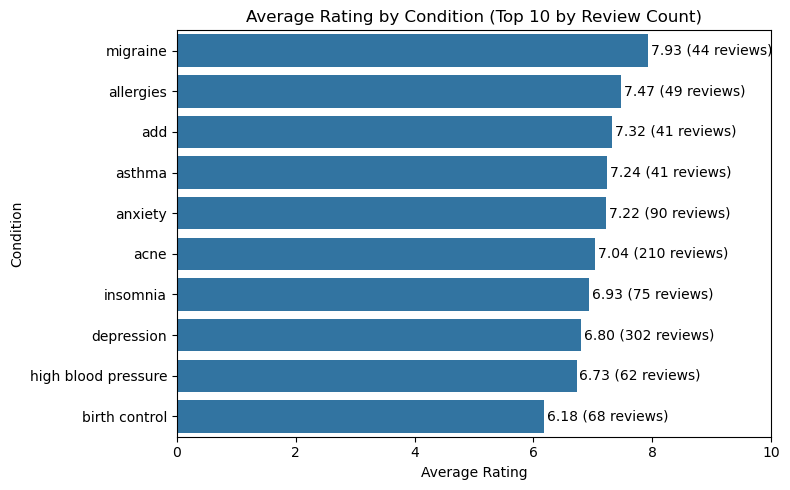

In [21]:
# Plotting
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=top10_for_plot["avg_rating"],
    y=top10_for_plot.index
)
plt.title("Average Rating by Condition (Top 10 by Review Count)")
plt.xlabel("Average Rating")
plt.ylabel("Condition")
# Show average rating numbers on bars
for i, (avg, cnt) in enumerate(
    zip(top10_for_plot["avg_rating"], top10_for_plot["review_count"])
):
    ax.text(avg + 0.05, i, f"{avg:.2f} ({cnt} reviews)", va="center")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

### Top drugs by avg rating.

In [23]:
# Filter to drugs with a minimum number of reviews to reduce noise from very small samples.

# Grouping by drug and for each calculating the avg rating
drug_stats = (
    df.groupby("urlDrugName")["rating"]
      .agg(avg_rating="mean", review_count="size").dropna())

# Keeping only drugs with a minimum number of 15 reviews
min_reviews = 15
drug_stats_filtered = drug_stats[drug_stats["review_count"] >= min_reviews]

# Taking top 10 drugs by average rating
top10_drugs = drug_stats_filtered.sort_values("avg_rating", ascending=False).head(10)

print(top10_drugs)

               avg_rating  review_count
urlDrugName                            
valtrex          8.678571            28
meridia          8.500000            16
flonase          8.333333            30
adderall         8.260870            23
vyvanse          8.222222            27
protonix         8.210526            19
zomig            8.200000            20
xanax            8.193548            31
metformin        8.050000            20
wellbutrin-xl    7.971429            35


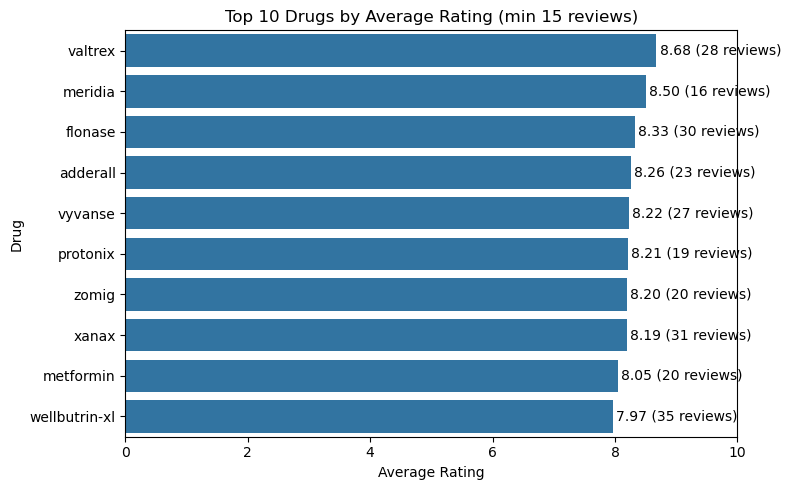

In [24]:
# Plotting
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=top10_drugs["avg_rating"],
    y=top10_drugs.index
)
plt.title(f"Top 10 Drugs by Average Rating (min {min_reviews} reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Drug")
# Show avg rating + review count on bars
for i, (avg, cnt) in enumerate(
    zip(top10_drugs["avg_rating"], top10_drugs["review_count"])
):
    ax.text(avg + 0.05, i, f"{avg:.2f} ({cnt} reviews)", va="center")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

### Distinctive terms by rating-derived sentiment label (train only)

In [26]:
# Use the training split only to avoid data leakage after combining splits for EDA
df_train = df[df["split"] == "train"]

In [27]:
TFIDF_MAX_FEATURES = 5000
TFIDF_NGRAM_RANGE = (1, 2)
TFIDF_MIN_DF = 5

# TF‑IDF top terms helper
vectorizer = TfidfVectorizer(
    max_features=TFIDF_MAX_FEATURES,
    ngram_range=TFIDF_NGRAM_RANGE,
    min_df=TFIDF_MIN_DF,
    stop_words="english",
)

for label in ["positive", "negative"]:
    sub = df_train[df_train["sentiment_label"] == label]

    X = vectorizer.fit_transform(sub["overall_review"])
    terms = np.array(vectorizer.get_feature_names_out())
    tfidf_means = np.asarray(X.mean(axis=0)).ravel()
    top_idx = tfidf_means.argsort()[::-1][:15]
    print(f"\nTop terms for {label} reviews (train only):")
    for t, v in zip(terms[top_idx], tfidf_means[top_idx]):
        print(f"{t:25s} {v:.4f}")


Top terms for positive reviews (train only):
day                       0.0307
effects                   0.0269
taking                    0.0259
pain                      0.0259
drug                      0.0232
medication                0.0221
skin                      0.0220
treatment                 0.0198
time                      0.0198
did                       0.0191
days                      0.0185
mg                        0.0177
sleep                     0.0176
took                      0.0176
years                     0.0170

Top terms for negative reviews (train only):
pain                      0.0374
drug                      0.0343
day                       0.0336
effects                   0.0335
taking                    0.0320
did                       0.0309
medication                0.0256
severe                    0.0244
took                      0.0243
days                      0.0241
treatment                 0.0240
skin                      0.0239
time             

It’s interesting that “pain/drugs” show up for negative while “effects/taking” show up for positive. My read is: positive reviews focus more on how the medication works, while negative reviews focus more on symptoms and discomfort.
Terms related to side effects, drugs, and treatment duration appear prominently across both classes.

## Sentiment Modeling



### Lexicon baseline: VADER
This section uses VADER (a lexicon-based sentiment tool) as a lightweight baseline.  
We compare its predicted labels to rating-derived sentiment labels.


In [31]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Ensure VADER lexicon is available (no-op if already downloaded)
nltk.download("vader_lexicon", quiet=True)

sia = SentimentIntensityAnalyzer()

In [32]:
# Quick sanity-check examples
examples = [
    "This drug worked great with no side effects.",
    "This medication made me feel awful with severe nausea.",
    "The treatment was okay, nothing special."
]

for text in examples:
    scores = sia.polarity_scores(text)
    print(f"Text: {text}")
    print(f"Scores: {scores}")
    print(f"Compound = {scores['compound']:.3f} -> "
          f"{'positive' if scores['compound'] > 0 else 'negative'}\n")

Text: This drug worked great with no side effects.
Scores: {'neg': 0.179, 'neu': 0.488, 'pos': 0.333, 'compound': 0.4404}
Compound = 0.440 -> positive

Text: This medication made me feel awful with severe nausea.
Scores: {'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.6808}
Compound = -0.681 -> negative

Text: The treatment was okay, nothing special.
Scores: {'neg': 0.277, 'neu': 0.49, 'pos': 0.233, 'compound': -0.092}
Compound = -0.092 -> negative



In [33]:
# Applying VADER to the dataset

# Computing VADER compound score for each review
df["vader_compound"] = df["overall_review"].astype(str).apply(
    lambda text: sia.polarity_scores(text)["compound"]
)

# Converting compound score to pos/neg labels based on the given rule
df["vader_label"] = np.where(df["vader_compound"] > 0, "positive", "negative")

# Preview a few rows (truncate review text for readability)
sample = (
    df[["overall_review", "rating", "sentiment_label", "vader_compound", "vader_label"]]
    .head(5)
    .copy()
)
sample["overall_review"] = sample["overall_review"].str.slice(0, 120) + "..."
print("\nSample of VADER vs rating-based label:\n")
print(sample)


Sample of VADER vs rating-based label:

                                      overall_review  rating sentiment_label  \
0  slowed the progression of left ventricular dys...       4        negative   
1  Although this type of birth control has more c...       1        negative   
2  I was used to having cramps so badly that they...      10        positive   
3  The acid reflux went away for a few months aft...       3        negative   
4  I think that the Lyrica was starting to help w...       2        negative   

   vader_compound vader_label  
0         -0.9666    negative  
1         -0.8945    negative  
2          0.6297    positive  
3         -0.6486    negative  
4         -0.5719    negative  


Calculate the accuracy score

In [35]:
# Compute accuracy separately on train and test splits
df_train = df[df["split"] == "train"]
df_test  = df[df["split"] == "test"]

# Calculating accuracy score
vader_acc_train = accuracy_score(df_train["sentiment_label"], df_train["vader_label"])
vader_acc_test  = accuracy_score(df_test["sentiment_label"],  df_test["vader_label"])

print(f"\nVADER accuracy on TRAIN set: {vader_acc_train:.3f}")
print(f"VADER accuracy on TEST set : {vader_acc_test:.3f}")


VADER accuracy on TRAIN set: 0.543
VADER accuracy on TEST set : 0.527


VADER achieves about 54% accuracy on the training set and 53% on the test set, which indicates only slightly better predictive power when compared to our rating-based sentiment labels.

### Transformer embeddings (Bio_ClinicalBERT) + Logistic Regression

This section uses Bio_ClinicalBERT to encode reviews into fixed-length embeddings, followed by a Logistic Regression classifier trained on rating-derived sentiment labels. Bio_ClinicalBERT is used as a frozen encoder; only the classifier is trained on this dataset.


In [39]:
import torch
from transformers import AutoTokenizer, AutoModel

MODEL_ID = "emilyalsentzer/Bio_ClinicalBERT"
tok = AutoTokenizer.from_pretrained(MODEL_ID)
device = "cuda" if torch.cuda.is_available() else "cpu"
mdl = AutoModel.from_pretrained(MODEL_ID).eval().to(device)
print("Device:", device)

Device: cuda


In [40]:
def encode_mean(texts, max_len=256):
    enc = tok(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
    enc = {k: v.to(mdl.device) for k, v in enc.items()}
    with torch.no_grad():
        out = mdl(**enc).last_hidden_state
        attn = enc["attention_mask"].unsqueeze(-1)
        mean_emb = (out * attn).sum(1) / attn.sum(1).clamp_min(1e-9)
    return mean_emb.cpu().numpy()

BATCH_SIZE = 16

def encode_batched(texts, batch_size=BATCH_SIZE, max_len=256):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        embs.append(encode_mean(batch, max_len=max_len))
    return np.vstack(embs)

In [41]:
# Splitting into train and test sets 
df_train = df[df["split"] == "train"]
df_test  = df[df["split"] == "test"]
X_train_text = df_train["overall_review"].astype(str).tolist()
X_test_text  = df_test["overall_review"].astype(str).tolist()

# sentiment_label, 1=positive, 0=negative
y_train = np.where(df_train["sentiment_label"] == "positive", 1, 0)
y_test  = np.where(df_test["sentiment_label"] == "positive", 1, 0)

print("Train size:", len(X_train_text))
print("Test size :", len(X_test_text))

# Convert texts to Bio_ClinicalBERT embeddings
X_train = encode_batched(X_train_text)
X_test  = encode_batched(X_test_text)

# Building and training the classifier on the training set using the BioBert embeddings and using LogReg for classifying
clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf.fit(X_train, y_train)

# Evaluating on the train and test sets
y_pred_train = clf.predict(X_train)
y_pred_test  = clf.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test, y_pred_test)

print("\nBio_ClinicalBERT + LogisticRegression accuracy:")
print("Train accuracy:", acc_train)
print("Test accuracy :", acc_test)

print("\nClassification report on TEST set:")
print(classification_report(y_test, y_pred_test, target_names=["negative", "positive"]))

Train size: 3106
Test size : 1036

Bio_ClinicalBERT + LogisticRegression accuracy:
Train accuracy: 0.9079201545396007
Test accuracy : 0.7615830115830116

Classification report on TEST set:
              precision    recall  f1-score   support

    negative       0.61      0.54      0.57       308
    positive       0.81      0.86      0.83       728

    accuracy                           0.76      1036
   macro avg       0.71      0.70      0.70      1036
weighted avg       0.75      0.76      0.76      1036



In [42]:
def polarity_from_clinicalbert(text: str):
    if text is None or not str(text).strip():
        return 0.0, "negative"
    emb = encode_mean([text])
    prob = clf.predict_proba(emb)[0]  # aligned to clf.classes_
    neg_idx = int(np.where(clf.classes_ == 0)[0][0])
    pos_idx = int(np.where(clf.classes_ == 1)[0][0])
    score = prob[pos_idx] - prob[neg_idx]
    label = "positive" if score > 0 else "negative"
    return float(score), label

In [43]:
# Demo on a few reviews
print("\nBio_ClinicalBERT polarity on a few sample train reviews:\n")
for text in df_train["overall_review"].head(3):
    score, label = polarity_from_clinicalbert(text)
    preview = text.replace("\n", " ")[:120] + "..."
    print(f"Text: {preview}")
    print(f"Score: {score:.3f}, Label: {label}\n")


Bio_ClinicalBERT polarity on a few sample train reviews:

Text: slowed the progression of left ventricular dysfunction into overt heart failure alone or with other agents in the managm...
Score: -1.000, Label: negative

Text: Although this type of birth control has more cons than pros, it did help with my cramps. It's also effective with the pr...
Score: -0.231, Label: negative

Text: I was used to having cramps so badly that they would leave me balled up in bed for at least 2 days. The Ponstel doesn't ...
Score: 0.867, Label: positive



### Score distribution diagnostics
This section compares score distributions for VADER (compound) and the embedding-based classifier (polarity score) against rating-derived sentiment labels.

In [45]:
# Compute ClinicalBERT-based polarity scores in batches to reduce inference overhead.
# Encoding one review at a time is inefficient (kernel launch + data transfer per call),
# even on GPU. Batch encoding amortizes this cost and improves device utilization.

texts = df["overall_review"].astype(str).tolist()

# Encode all reviews into embeddings using batched inference
embs = encode_batched(texts, batch_size=BATCH_SIZE)

# Predict class probabilities with the trained Logistic Regression classifier
# (probability order is defined by clf.classes_)
probs = clf.predict_proba(embs)

# Compute signed polarity score as p(positive) - p(negative)
neg_idx = int(np.where(clf.classes_ == 0)[0][0])
pos_idx = int(np.where(clf.classes_ == 1)[0][0])
df["clinicalbert_score"] = probs[:, pos_idx] - probs[:, neg_idx]


negative peaks:
  peak 1: density = 0.7296 at score -0.8297
  peak 2: density = 0.6189 at score 0.8153

positive peaks:
  peak 1: density = 1.1992 at score -0.8851
  peak 2: density = 0.2655 at score 0.6717


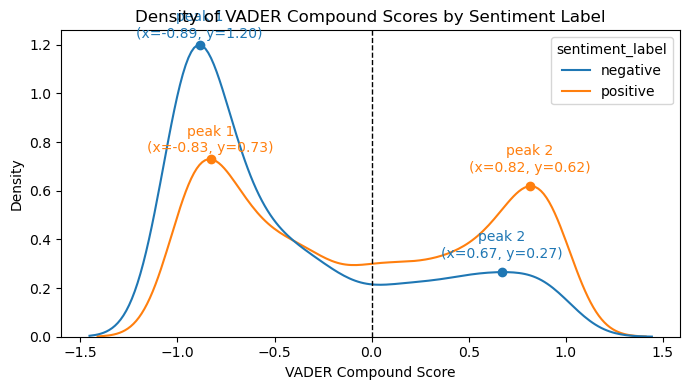

peak 1: density = 2.9409 at score 0.9669
peak 2: density = 0.0563 at score -0.6167
peak 1: density = 0.9455 at score -0.8907
peak 2: density = 0.2599 at score 0.8612


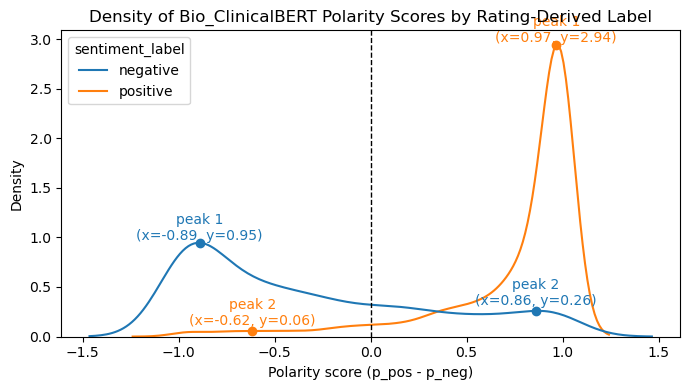

In [46]:
plot_vader_density_with_peaks(df)
plot_clinicalbert_density_with_peaks(df)

**Interpretation**

- **VADER (compound score):** The distribution of VADER compound scores shows substantial overlap between rating-derived positive and negative labels. While negative reviews tend to cluster more strongly at lower scores, the bimodality of the distribution and overlap near zero indicate that a rule-based lexicon approach struggles with the mixed and nuanced sentiment common in medical reviews.

- **Bio_ClinicalBERT embeddings + Logistic Regression (polarity score):** The learned polarity scores derived from the classifier show clearer separation between classes, particularly for positive reviews. Residual overlap—especially where negative reviews receive positive polarity—likely reflects sentiment ambiguity in patient narratives and noise introduced by using ratings as a proxy label.

Overall, Bio_ClinicalBERT performs better than VADER at separating positive and negative reviews, with notably stronger performance on positive sentiment. Performance drops for negative sentiment, which may reflect the greater nuance of negative reviews and the class imbalance in the dataset.
